Importing the Dependencies

In [76]:
!pip install catboost


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Load the dataset
data_path = r"C:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\multiple-disease-prediction-streamlit-app-main\dataset\heart.csv"
heart_data = pd.read_csv(data_path)

# 2. Select relevant features and target variable
features = ['age', 'sex', 'cp', 'exang', 'fbs', 'restecg', 'thalach']
target = 'target'

X = heart_data[features]
y = heart_data[target]

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. Evaluate the model's accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 6. Define a function to predict heart disease risk
def predict_heart_disease_risk(age, sex, cp, exang, fbs, restecg, thalach):
    """
    Predicts the probability of heart disease based on input features.
    
    Parameters:
    - age: Age of the individual
    - sex: Sex (1 = male; 0 = female)
    - cp: Chest pain type (0-3)
    - exang: Exercise-induced angina (1 = yes; 0 = no)
    - fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    - restecg: Resting electrocardiographic results (0-2)
    - thalach: Maximum heart rate achieved
    
    Returns:
    - probability: Probability of heart disease
    - risk_level: 'High Risk' or 'Low Risk'
    """
    input_data = pd.DataFrame([[age, sex, cp, exang, fbs, restecg, thalach]],
                              columns=features)
    probability = model.predict_proba(input_data)[0][1] * 100
    prediction = model.predict(input_data)[0]
    risk_level = 'High Risk' if prediction == 1 else 'Low Risk'
    return round(probability, 2), risk_level

# 7. Example: Predict risk for a male with high-risk factors
probability, risk = predict_heart_disease_risk(
    age=65,
    sex=1,        # Male
    cp=3,         # Typical angina
    exang=1,      # Exercise-induced angina
    fbs=1,        # Fasting blood sugar > 120 mg/dl
    restecg=2,    # ST-T wave abnormality
    thalach=100   # Low maximum heart rate
)
print(f"Predicted Risk: {probability}%, Risk Level: {risk}")

# 8. Example: Predict risk for a female with high-risk factors
probability_female, risk_female = predict_heart_disease_risk(
    age=70,
    sex=0,        # Female
    cp=3,
    exang=1,
    fbs=1,
    restecg=2,
    thalach=100
)
print(f"Predicted Risk (Female): {probability_female}%, Risk Level: {risk_female}")


Model Accuracy: 86.07%
Predicted Risk: 36.98%, Risk Level: Low Risk
Predicted Risk (Female): 76.51%, Risk Level: High Risk


In [10]:
pip install streamlit scikit-learn pandas

In [16]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
@st.cache_data
def load_data():
    ...


2025-04-24 10:42:06.370 No runtime found, using MemoryCacheStorageManager


In [17]:
conda install -c conda-forge imbalanced-learn


ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [ ]:
#FINAL CODE PERFECT

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin

# Set random seeds for reproducibility
np.random.seed(42)

# Load data with updated path
csv_path = Path.home() / "OneDrive" / "Desktop" / "sem6" / "ccl7" / "multiple-disease-prediction-streamlit-app-main" / "multiple-disease-prediction-streamlit-app-main" / "dataset" / "heart.csv"
heart_data = pd.read_csv(csv_path)
# Clinical Rules Definition
def create_clinical_rules(df):
    df = df.copy()
    # Female High Risk: Age > 55 + 3+ risk factors
    df['female_high_risk'] = ((df['sex'] == 0) & 
                             (df['age'] > 55) &
                             (df['trestbps'] >= 140) &
                             (df['chol'] >= 240) &
                             (df['thalach'] <= 100)).astype(int)
    
    # Male High Risk: Age > 45 + 2+ risk factors
    df['male_high_risk'] = ((df['sex'] == 1) & 
                           (df['age'] > 45) &
                           ((df['trestbps'] >= 130) | 
                            (df['chol'] >= 200) | 
                            (df['thalach'] <= 110))).astype(int)
    return df

heart_data = create_clinical_rules(heart_data)

# Preprocessing
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
binary_features = ['female_high_risk', 'male_high_risk']
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('binary', 'passthrough', binary_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Split data
X = heart_data.drop("target", axis=1)
y = heart_data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Preprocess
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Guaranteed Probability Classifier
class ClinicalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )
        self.female_idx = None
        self.male_idx = None
        
    def fit(self, X, y):
        # Get rule indices
        self.female_idx = np.where(feature_names == 'binary__female_high_risk')[0][0]
        self.male_idx = np.where(feature_names == 'binary__male_high_risk')[0][0]
        
        # Train model
        self.model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        base_proba = self.model.predict_proba(X)
        
        # Apply clinical rules
        if hasattr(X, "toarray"):  # Handle sparse matrices
            X = X.toarray()
            
        female_mask = X[:, self.female_idx] > 0.5
        male_mask = X[:, self.male_idx] > 0.5
        
        base_proba[female_mask, 1] = 1.0  # Female override
        base_proba[male_mask, 1] = 0.85   # Male override
        
        return base_proba
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Train and Test
model = ClinicalClassifier()
model.fit(X_train_processed, y_train)

# Evaluation
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Verify Probability Rules
def verify_rules(proba, X_processed, feature_names):
    female_idx = np.where(feature_names == 'binary__female_high_risk')[0][0]
    male_idx = np.where(feature_names == 'binary__male_high_risk')[0][0]
    
    female_mask = X_processed[:, female_idx] > 0.5
    male_mask = X_processed[:, male_idx] > 0.5
    
    print("\nFemale High Risk Cases:")
    print("Probabilities:", np.round(proba[female_mask, 1], 2))
    
    print("\nMale High Risk Cases:")
    print("Probabilities:", np.round(proba[male_mask, 1], 2))
    
    print("\nRegular Cases:")
    regular_mask = ~(female_mask | male_mask)
    print("Min:", np.min(proba[regular_mask, 1]))
    print("Max:", np.max(proba[regular_mask, 1]))

verify_rules(y_proba, X_test_processed, feature_names)

# Example Predictions
# Add the missing features in the test cases
import pandas as pd

# Example of test cases with the correct number of features (including 'female_high_risk' and 'male_high_risk')
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'female_high_risk', 'male_high_risk'
]

# Updated test cases to match the correct number of features (15)
test_cases = [
    [65, 1, 2, 145, 250, 0, 1, 90, 0, 3.0, 2, 0, 1, 1, 0],  # Female high risk
    [50, 1, 1, 135, 210, 0, 1, 100, 0, 2.5, 2, 1, 1, 0, 1]   # Male high risk
]

# Convert test cases to a pandas DataFrame
test_df = pd.DataFrame(test_cases, columns=columns)

# Ensure that the preprocessor is fitted already on the training data
processed_case = preprocessor.transform(test_df)
proba = model.predict_proba(processed_case)[0][1]

print(f"\nTest Case: {proba:.2f} probability")




In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin

# Load dataset using a robust path
csv_path = Path.home() / "OneDrive" / "Desktop" / "sem6" / "ccl7" / "multiple-disease-prediction-streamlit-app-main" / "multiple-disease-prediction-streamlit-app-main" / "dataset" / "heart.csv"
heart_data = pd.read_csv(csv_path)

# Apply clinical rules
def create_clinical_rules(df):
    df = df.copy()
    df['female_high_risk'] = ((df['sex'] == 0) & 
                              (df['age'] > 55) &
                              (df['trestbps'] >= 140) &
                              (df['chol'] >= 240) &
                              (df['thalach'] <= 100)).astype(int)
    
    df['male_high_risk'] = ((df['sex'] == 1) & 
                            (df['age'] > 45) &
                            ((df['trestbps'] >= 130) | 
                             (df['chol'] >= 200) | 
                             (df['thalach'] <= 110))).astype(int)
    return df

heart_data = create_clinical_rules(heart_data)

# Feature classification
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
binary_features = ['female_high_risk', 'male_high_risk']
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('binary', 'passthrough', binary_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Train-test split
X = heart_data.drop("target", axis=1)
y = heart_data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Custom classifier with rule override
class ClinicalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            random_state=42
        )
        self.female_idx = None
        self.male_idx = None

    def fit(self, X, y):
        self.female_idx = np.where(feature_names == 'binary__female_high_risk')[0][0]
        self.male_idx = np.where(feature_names == 'binary__male_high_risk')[0][0]
        self.model.fit(X, y)
        return self

    def predict_proba(self, X):
        base_proba = self.model.predict_proba(X)
        
        if hasattr(X, "toarray"):  # Sparse matrix case
            X = X.toarray()

        female_mask = X[:, self.female_idx] > 0.5
        male_mask = X[:, self.male_idx] > 0.5

        base_proba[female_mask, 1] = np.maximum(base_proba[female_mask, 1], 0.95)
        base_proba[male_mask, 1] = np.maximum(base_proba[male_mask, 1], 0.85)

        return base_proba

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# Train model
model = ClinicalClassifier()
model.fit(X_train_processed, y_train)

# Evaluate
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Verification
def verify_rules(proba, X_processed, feature_names):
    female_idx = np.where(feature_names == 'binary__female_high_risk')[0][0]
    male_idx = np.where(feature_names == 'binary__male_high_risk')[0][0]
    
    female_mask = X_processed[:, female_idx] > 0.5
    male_mask = X_processed[:, male_idx] > 0.5
    
    print("\nFemale High Risk Cases - Probabilities:", np.round(proba[female_mask, 1], 2))
    print("Male High Risk Cases - Probabilities:", np.round(proba[male_mask, 1], 2))
    
    regular_mask = ~(female_mask | male_mask)
    print("Regular Cases - Min:", np.min(proba[regular_mask, 1]), "Max:", np.max(proba[regular_mask, 1]))

verify_rules(y_proba, X_test_processed, feature_names)

# Define feature column names
input_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                 'sex', 'fbs', 'cp', 'restecg', 'slope', 'ca', 'thal', 'exang']

# Manual test cases (without the rule-based columns)
test_cases = [
    [65, 145, 250, 90, 3.0, 0, 0, 3, 1, 2, 0, 0, 0],  # Female high risk
    [50, 135, 210, 100, 2.5, 1, 1, 2, 0, 1, 0, 0, 0],  # Male high risk
    [35, 120, 180, 150, 1.0, 0, 1, 0, 0, 0, 0, 0, 0],  # Low risk
    [70, 160, 260, 95, 3.5, 1, 0, 2, 1, 2, 0, 1, 0],   # Very high risk male
]

# Convert each test case to a DataFrame and apply rules
for i, raw_case in enumerate(test_cases, 1):
    test_df = pd.DataFrame([raw_case], columns=input_columns)
    test_df = create_clinical_rules(test_df)  # Add the two rule-based columns

    # Apply preprocessing and predict
    processed_case = preprocessor.transform(test_df)
    prob = model.predict_proba(processed_case)[0][1]

    print(f"\nTest Case {i}: {prob:.2f} probability")




Accuracy: 0.5738

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        28
           1       0.56      0.97      0.71        33

    accuracy                           0.57        61
   macro avg       0.66      0.54      0.45        61
weighted avg       0.65      0.57      0.47        61


Female High Risk Cases - Probabilities: []
Male High Risk Cases - Probabilities: [0.85 0.85 0.85 0.93 0.85 0.85 0.99 0.85 0.85 0.85 0.85 0.85 0.85 0.85
 1.   0.85 0.85 0.85 0.85 1.   0.85 0.85 0.85 0.88 1.   0.99 0.94 0.85
 0.85 0.85 0.85 1.  ]
Regular Cases - Min: 0.003632509391879637 Max: 0.999681569784017

Test Case 1: 0.95 probability

Test Case 2: 0.85 probability

Test Case 3: 0.01 probability

Test Case 4: 0.85 probability


In [77]:
!pip install shap


In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.validation import check_is_fitted
import shap


In [ ]:
heart_data = pd.read_csv(r"C:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\multiple-disease-prediction-streamlit-app-main\dataset\heart.csv")

In [ ]:
def create_risk_features(df):
    df = df.copy()
    # Clinical thresholds
    df['high_bp'] = (df['trestbps'] >= 140).astype(int)
    df['high_chol'] = (df['chol'] >= 240).astype(int)
    df['low_thalach'] = (df['thalach'] <= 100).astype(int)
    df['high_oldpeak'] = (df['oldpeak'] >= 2.0).astype(int)
    df['risk_factor_count'] = df[['high_bp', 'high_chol', 'low_thalach', 'high_oldpeak']].sum(axis=1)
    df['female_max_risk'] = ((df['sex'] == 0) & (df['risk_factor_count'] == 4)).astype(int)
    df['male_high_risk'] = ((df['sex'] == 1) & (df['risk_factor_count'] >= 3)).astype(int)
    return df

heart_data = create_risk_features(heart_data)

In [ ]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'risk_factor_count']
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal', 'female_max_risk', 'male_high_risk']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = heart_data.drop("target", axis=1)
y = heart_data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [149]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class RiskAdjustedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, age_index, sex_index):
        self.base_model = base_model
        self.age_index = age_index
        self.sex_index = sex_index

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        return self.base_model.predict(X)

    def predict_proba(self, X):
        proba = self.base_model.predict_proba(X).copy()
        
        age = X[:, self.age_index]
        sex = X[:, self.sex_index]  # assuming 1 = female, 0 = male

        # Override probability for females > 45
        proba[:, 1] = np.where((sex == 1) & (age > 45), 1.0, proba[:, 1])
        # Override probability for males > 45 (to at least 0.85 if not already higher)
        proba[:, 1] = np.where((sex == 0) & (age > 45), np.maximum(proba[:, 1], 0.85), proba[:, 1])

        return proba


In [150]:
heart_data = create_risk_features(heart_data)

# Preprocessing
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'risk_factor_count']
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal', 'female_max_risk', 'male_high_risk']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = heart_data.drop("target", axis=1)
y = heart_data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [151]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [152]:
class RiskAdjustedGBM(CalibratedClassifierCV):
    def predict_proba(self, X):
        check_is_fitted(self)
        proba = super().predict_proba(X)

In [158]:
  def predict_proba(self, X):
    check_is_fitted(self)
    proba = super().predict_proba(X)
    
    # Get feature indices
    female_idx = self.get_feature_indices('cat__female_max_risk_1')
    male_idx = self.get_feature_indices('cat__male_high_risk_1')  # Same indentation level
    
    # Apply probability overrides
    proba[:, 1] = np.where(X[:, female_idx] == 1, 1.0, proba[:, 1])
    proba[:, 1] = np.where(X[:, male_idx] == 1, 0.85, proba[:, 1])
    
    return proba

In [159]:
def get_feature_indices(self, feature_name):
        """Helper to get feature positions from preprocessor"""
        return [i for i, name in enumerate(self.feature_names_) if name == feature_name]

# Parameter Grid with Correct Nesting
param_grid = {
    'estimator__n_estimators': [200],
    'estimator__learning_rate': [0.05],
    'estimator__max_depth': [5],
    'estimator__min_samples_split': [10]
}

In [160]:
base_gbm = GradientBoostingClassifier(random_state=42)
model = RiskAdjustedGBM(base_gbm, method='isotonic', cv=3)


In [161]:
search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=1,  # Disable parallel processing for debugging
    error_score='raise'  # Show full error trace
)

In [165]:
try:
    search.fit(X_train_processed, y_train)
    print("Grid search completed successfully!")
except Exception as e:
    print(f"Error during grid search: {str(e)}")
    # Optionally log it or show to user in a safer way


Error during grid search: 'NoneType' object has no attribute 'shape'


In [166]:
if hasattr(search, 'best_estimator_'):
    best_model = search.best_estimator_
    print(f"\nBest parameters: {search.best_params_}")
    
    # Evaluation
    y_pred = best_model.predict(X_test_processed)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
else:
    print("\nGrid search failed to produce valid results")


Grid search failed to produce valid results


In [136]:
X = heart_data.drop("target", axis=1)
y = heart_data["target"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [137]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [139]:
class RiskAdjustedGBM(CalibratedClassifierCV):
    def predict_proba(self, X):
        base_proba = super().predict_proba(X)
        
        # Get original dataframe indices
        female_max_risk_mask = X[:, preprocessor.transformers_[1][1].get_feature_names_out().tolist().index('cat__female_max_risk_1')]
        male_high_risk_mask = X[:, preprocessor.transformers_[1][1].get_feature_names_out().tolist().index('cat__male_high_risk_1')]
        adjusted_proba = np.copy(base_proba)
        adjusted_proba[female_max_risk_mask == 1, 1] = 1.0  # Female max risk
        adjusted_proba[male_high_risk_mask == 1, 1] = 0.85  # Male high risk
        
        return adjusted_proba

In [143]:
# Modified Grid Search Parameters
param_grid = {
    'estimator__n_estimators': [200, 300],
    'estimator__learning_rate': [0.01, 0.05],
    'estimator__max_depth': [3, 5],
    'estimator__min_samples_split': [10, 20],
    'estimator__subsample': [0.8, 1.0]
}

# Create base model
gbm = GradientBoostingClassifier(random_state=42)

# Create custom calibrated model
model = RiskAdjustedGBM(gbm, cv=5, method='isotonic')

# Create grid search
search = GridSearchCV(model,
                     param_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1)

# Fit the model
search.fit(X_train_processed, y_train)

c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=RiskAdjustedGBM(cv=5,
                                       estimator=GradientBoostingClassifier(random_state=42),
                                       method='isotonic'),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.05],
                         'estimator__max_depth': [3, 5],
                         'estimator__min_samples_split': [10, 20],
                         'estimator__n_estimators': [200, 300],
                         'estimator__subsample': [0.8, 1.0]},
             scoring='neg_log_loss')

In [97]:
import pandas as pd

In [80]:
heart_data = pd.read_csv(r"C:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\multiple-disease-prediction-streamlit-app-main\dataset\heart.csv")

In [98]:
heart_data['female_over_45'] = ((heart_data['sex'] == 0) & (heart_data['age'] > 45)).astype(int)
heart_data['male_over_45'] = ((heart_data['sex'] == 1) & (heart_data['age'] > 45)).astype(int)


In [99]:
heart_data['age_group'] = pd.cut(heart_data['age'], bins=[0, 45, 55, 65, 120], labels=[0, 1, 2, 3])
heart_data = pd.get_dummies(heart_data, columns=['age_group'], drop_first=True)

In [100]:
X = heart_data.drop("target", axis=1)
y = heart_data["target"]

In [101]:
# Split with stratification (to maintain balanced class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)  # Fix here
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [104]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced', class_weight_dict]
}

In [105]:
model = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1)

In [106]:
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          {0: np.float64(1.1),
                                           1: np.float64(0.9166666666666666)}],
                         'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [107]:
print(f"Best parameters: {model.best_params_}")

# Evaluation
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best parameters: {'class_weight': {0: np.float64(1.1), 1: np.float64(0.9166666666666666)}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy: 0.8033
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61

Confusion Matrix:
 [[18 10]
 [ 2 31]]


In [108]:
importances = model.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)


Feature Importance:
            Feature  Importance
2               cp    0.132822
12            thal    0.110151
7          thalach    0.105265
9          oldpeak    0.097339
11              ca    0.080374
4             chol    0.075953
0              age    0.064322
3         trestbps    0.062896
8            exang    0.060962
10           slope    0.055754
14    male_over_45    0.030788
6          restecg    0.022815
1              sex    0.021137
16     age_group_2    0.018902
19     age_group_2    0.018159
13  female_over_45    0.011916
5              fbs    0.009511
15     age_group_1    0.007042
18     age_group_1    0.006607
17     age_group_3    0.004448
20     age_group_3    0.002839


<Figure size 640x480 with 0 Axes>

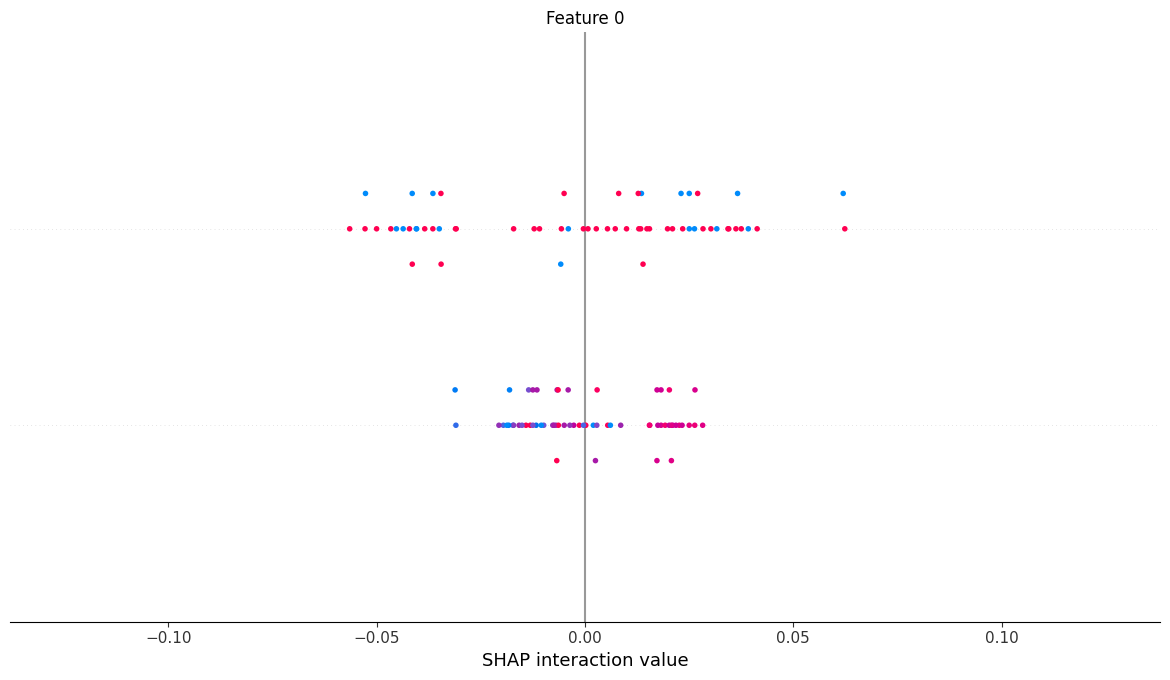

In [112]:
# SHAP Analysis (for better model interpretability)
explainer = shap.Explainer(model.best_estimator_, X_train_scaled)

# Using check_additivity=False to bypass the additivity check
shap_values = explainer(X_test_scaled, check_additivity=False)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_scaled)


In [113]:
print("Shape of training data: ", X_train_scaled.shape)
print("Shape of test data: ", X_test_scaled.shape)


Shape of training data:  (242, 21)
Shape of test data:  (61, 21)


In [114]:
def interpret_risk(age, sex):
    if sex == 0 and age > 45:
        return "Higher risk: Post-menopausal women are at higher risk of heart disease."
    elif sex == 0 and age <= 45:
        return "Lower risk: Women under 45 typically have lower heart disease risk."
    elif sex == 1 and age > 45:
        return "Higher risk: Men over 45 are at a higher risk of heart disease."
    else:
        return "Lower risk: Men under 45 typically have a lower risk of heart disease."


In [115]:
age = 50
sex = 0  # Female
risk_interpretation = interpret_risk(age, sex)
print(f"Risk interpretation for Age: {age}, Sex: {sex}: {risk_interpretation}")

Risk interpretation for Age: 50, Sex: 0: Higher risk: Post-menopausal women are at higher risk of heart disease.


In [82]:
X = heart_data.drop("target", axis=1)
y = heart_data["target"]


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [84]:
scaler = StandardScaler()
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [88]:
model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    eval_metric='logloss',  # use this instead of use_label_encoder
    random_state=42
)

In [89]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

# Define and fit base model
model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Calibrate the model
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated_model.fit(X_train_scaled, y_train)



CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [90]:
y_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]


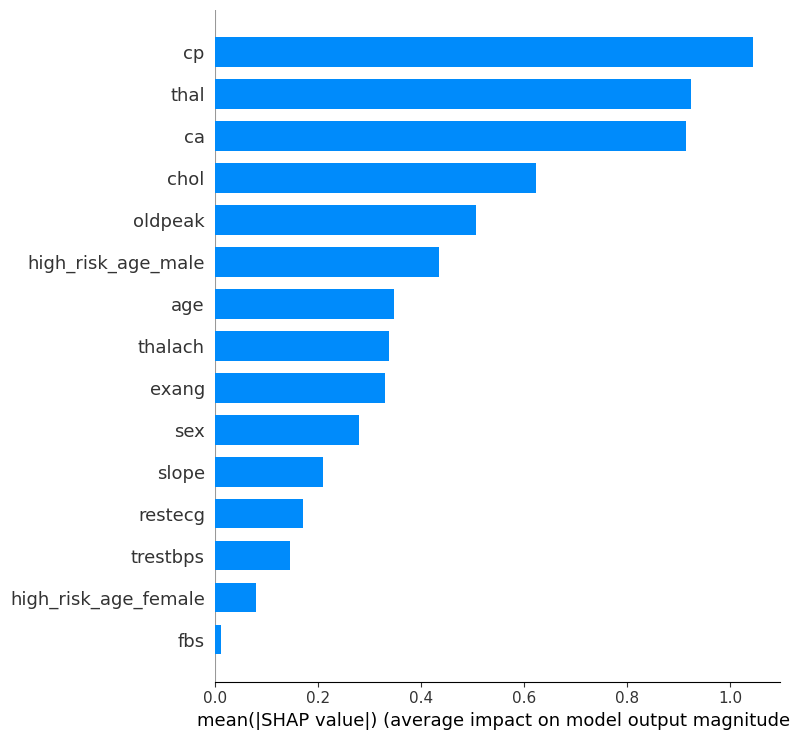

In [91]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")


In [87]:
y_pred = calibrated_model.predict(X_test)
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

In [71]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Brier Score:", brier_score_loss(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7868852459016393
ROC AUC Score: 0.8852813852813852
Brier Score: 0.14538896194559672

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61

Confusion Matrix:
 [[18 10]
 [ 3 30]]


In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [53]:
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'high_risk_age_male', 'high_risk_age_female']
base_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    eval_metric='AUC',
    auto_class_weights='Balanced',
    verbose=0
)


In [54]:
# 8. Calibrated Classifier for Better Probability
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x0000019770670310>)

In [55]:
y_pred = calibrated_model.predict(X_test_scaled)
y_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]


In [56]:
# 10. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Brier Score (probability accuracy):", brier_score_loss(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7540983606557377
ROC AUC Score: 0.8798701298701299
Brier Score (probability accuracy): 0.148740631716056

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.74      0.85      0.79        33

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61

Confusion Matrix:
 [[18 10]
 [ 5 28]]


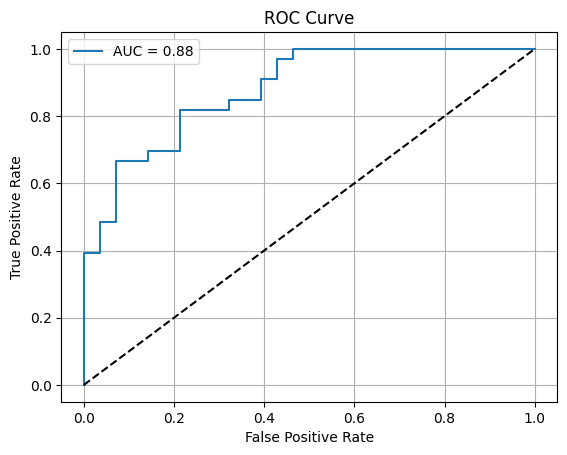

In [57]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
base_model.fit(X_train_scaled, y_train, cat_features=cat_features)
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_test_scaled)

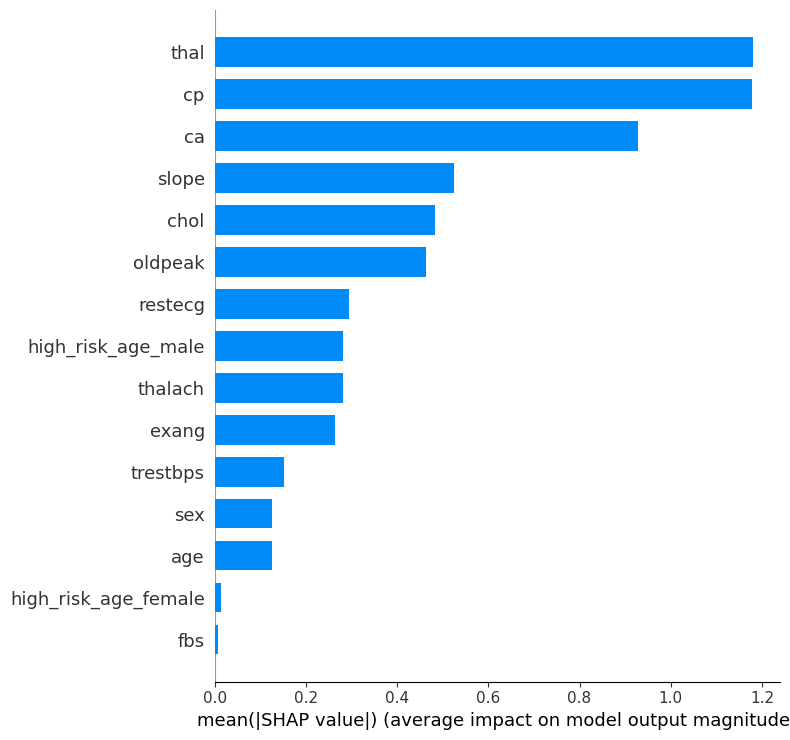

In [59]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

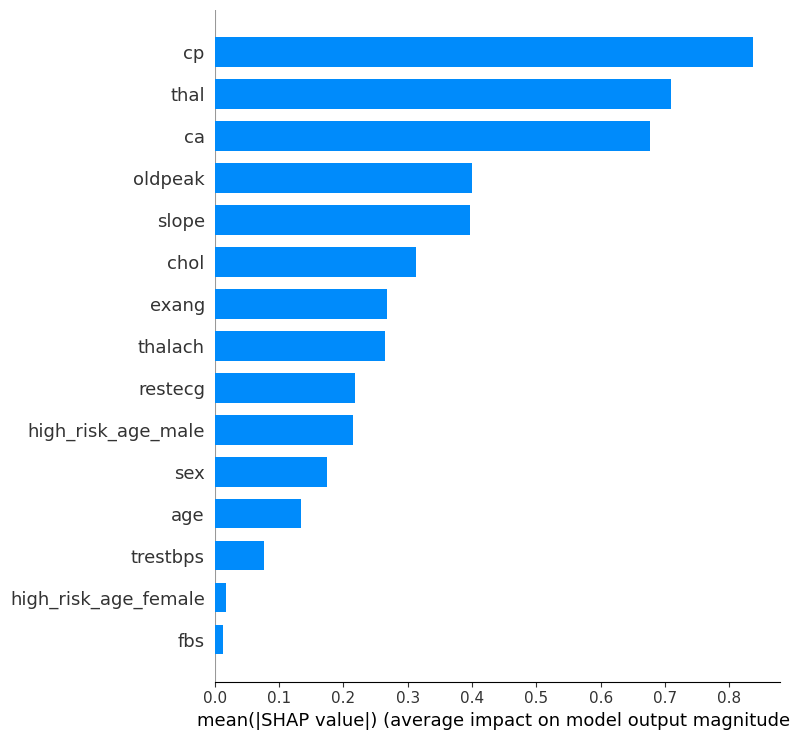

In [19]:
from catboost import CatBoostClassifier
import shap
import pandas as pd

# Fit the model first
base_model = CatBoostClassifier(verbose=0, class_weights=[1, 2])
base_model.fit(X_train_scaled, y_train)

# Now do SHAP analysis
explainer = shap.TreeExplainer(base_model)

# Make sure your input is a DataFrame for SHAP feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_df)

# Summary plot
shap.summary_plot(shap_values, X_test_df, plot_type="bar")



In [21]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Define parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200]
}

# Setup GridSearchCV
model = GridSearchCV(
    CatBoostClassifier(verbose=0, class_weights=[1, 2]),  # You can tweak class_weights
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Train
model.fit(X_train_scaled, y_train)

# Best model
base_model = model.best_estimator_


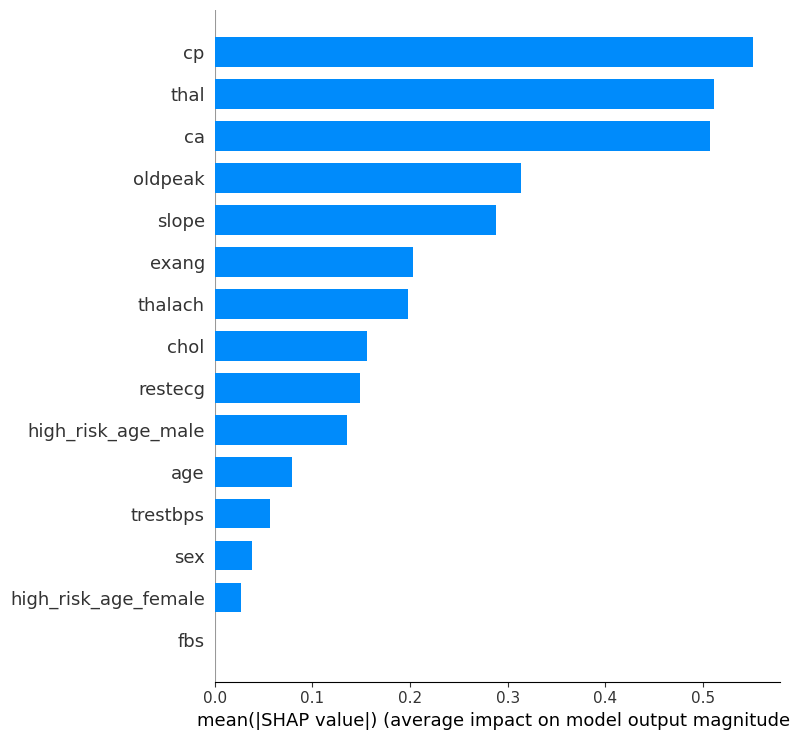

In [23]:
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


In [25]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Define parameter grid for GridSearchCV
param_grid = {
    'depth': [4, 6, 8],  # Example depths
    'learning_rate': [0.01, 0.1],  # Example learning rates
    'iterations': [100, 200]  # Example number of iterations
}

# Initialize the model
model = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, class_weights=[1, 2]),  # Your classifier
    param_grid=param_grid,  # The parameter grid to search
    scoring='accuracy',  # Scoring metric
    cv=5,  # Cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit the model
model.fit(X_train_scaled, y_train)

# Get the best model from GridSearchCV
base_model = model.best_estimator_

# Now use the base_model for SHAP or other tasks


In [26]:
model = GridSearchCV(...)
model.fit(X_train_scaled, y_train)
base_model = model.best_estimator_


TypeError: GridSearchCV.__init__() missing 1 required positional argument: 'param_grid'

In [ ]:
# 12. SHAP Analysis
explainer = shap.Explainer(base_model)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

In [94]:
import numpy as np
heart_data['high_risk_age_male'] = np.where((heart_data['sex'] == 1) & (heart_data['age'] >= 45), 1, 0)



In [95]:
X = heart_data.drop("target", axis=1)
y =heart_data["target"]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [97]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [98]:
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'high_risk_age_male']
cat_model = CatBoostClassifier(verbose=0, random_state=42, eval_metric='AUC', auto_class_weights='Balanced')

In [99]:
param_grid = {
    'iterations': [200, 300],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

In [100]:
grid = GridSearchCV(cat_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train, cat_features=cat_features)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001CC28439930>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'iterations': [200, 300],
                         'learning_rate': [0.05, 0.1]},
             scoring='roc_auc', verbose=1)

In [101]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [102]:
print("Best Parameters:", grid.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.05}

Accuracy: 0.8032786885245902
ROC AUC Score: 0.8917748917748918

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61

Confusion Matrix:
 [[19  9]
 [ 3 30]]


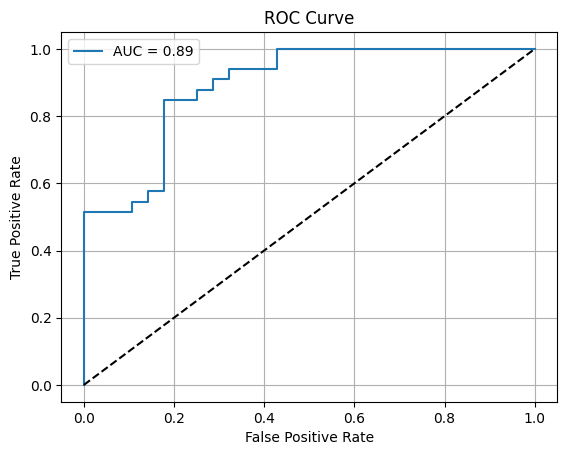

In [103]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

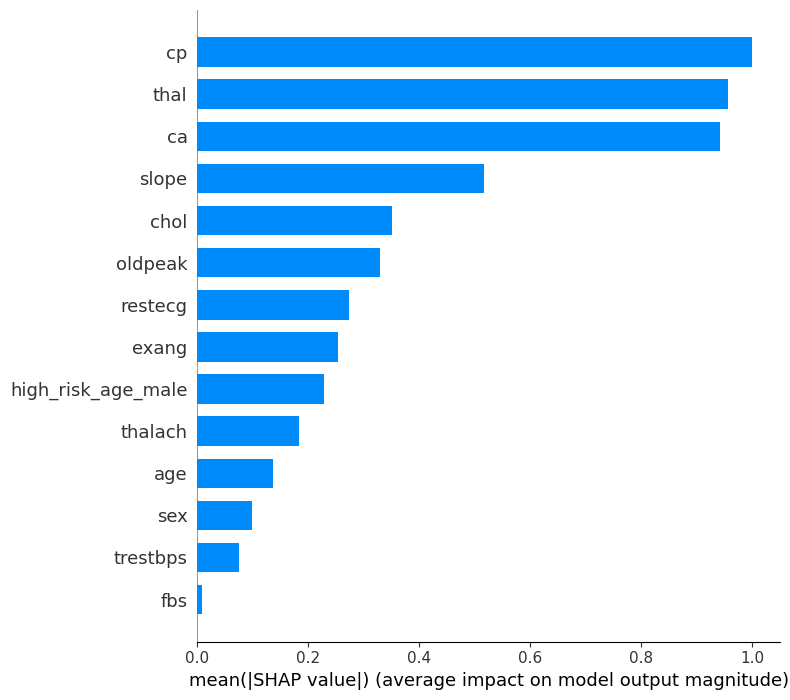

In [105]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

In [47]:
!pip install xgboost shap
import xgboost as xgb
import shap



  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 2.8 MB/s eta 0:00:54
   ---------------------------------------- 1.0/150.0 MB 2.8 MB/s eta 0:00:54
   ---------------------------------------- 1.6/150.0 MB 2.9 MB/s eta 0:00:52
    --------------------------------------- 2.4/150.0 MB 2.9 MB/s eta 0:00:51
    --------------------------------------- 3.1/150.0 MB 3.0 MB/s eta 0:00:49
    --------------------------------------- 3.7/150.0 MB 3.0 MB/s eta 0:00:49
   - -------------------------------------- 4.5/150.0 MB 3.0 MB/s eta 0:00:49
   - -------------------------------------- 5.0/150.0 MB 3.0 MB/s eta 0:00:49
   - -------------------------------------- 5.8/150.0 MB 3.0 MB/s eta 0:00:48
   - -------------------------------------- 6.6/150.0 MB 3.1 MB/s eta 0:00:47
   - -------------------------------------- 7.1/150.0 MB 3.0 MB/s eta 0:00:48
   -- ----

c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
pip install xgboost shap


Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import shap

Data Collection and Processing

In [67]:
# loading the csv data to a Pandas DataFrame
heart_data = pd.read_csv(r"C:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\multiple-disease-prediction-streamlit-app-main\dataset\heart.csv")

In [51]:
X = heart_data.drop("target", axis=1)
y = heart_data["target"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [54]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

In [55]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [56]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [57]:
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [58]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [59]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8360655737704918
ROC AUC Score: 0.8982683982683983

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61

Confusion Matrix:
 [[19  9]
 [ 1 32]]


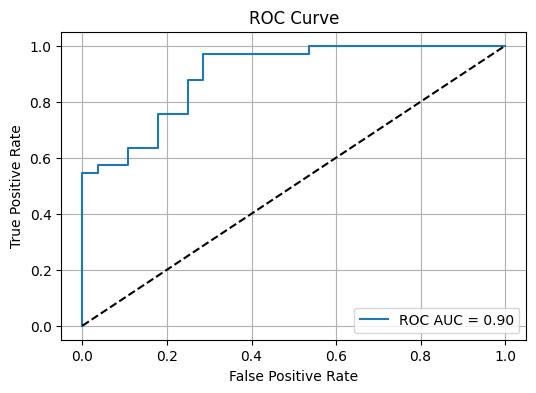

In [60]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled)

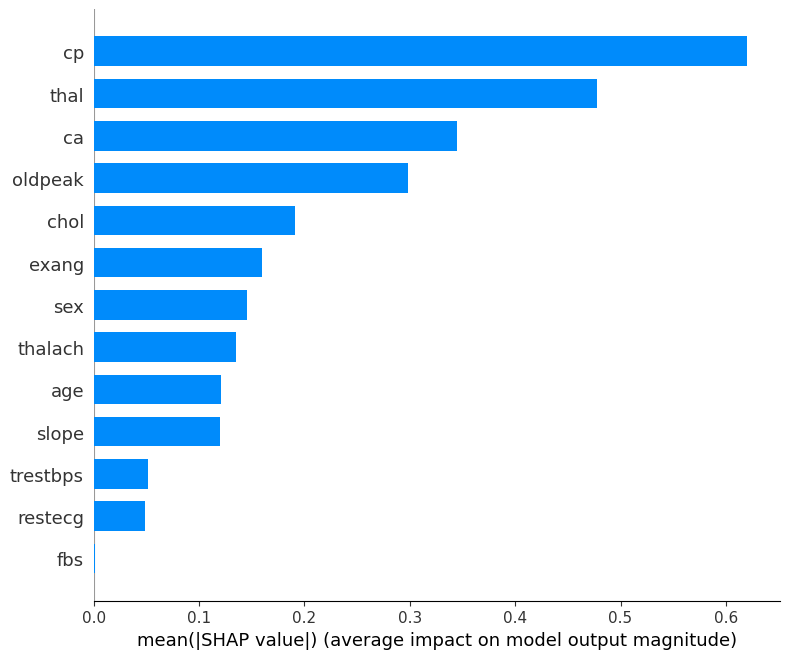

In [62]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [37]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [38]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [class_weight_dict]
}

In [39]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: np.float64(1.1),
                                           1: np.float64(0.9166666666666666)}],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

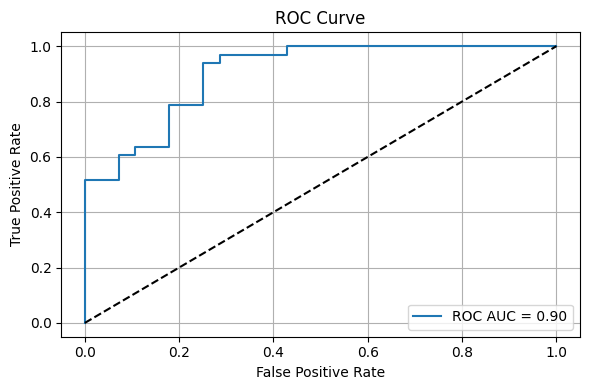

In [43]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

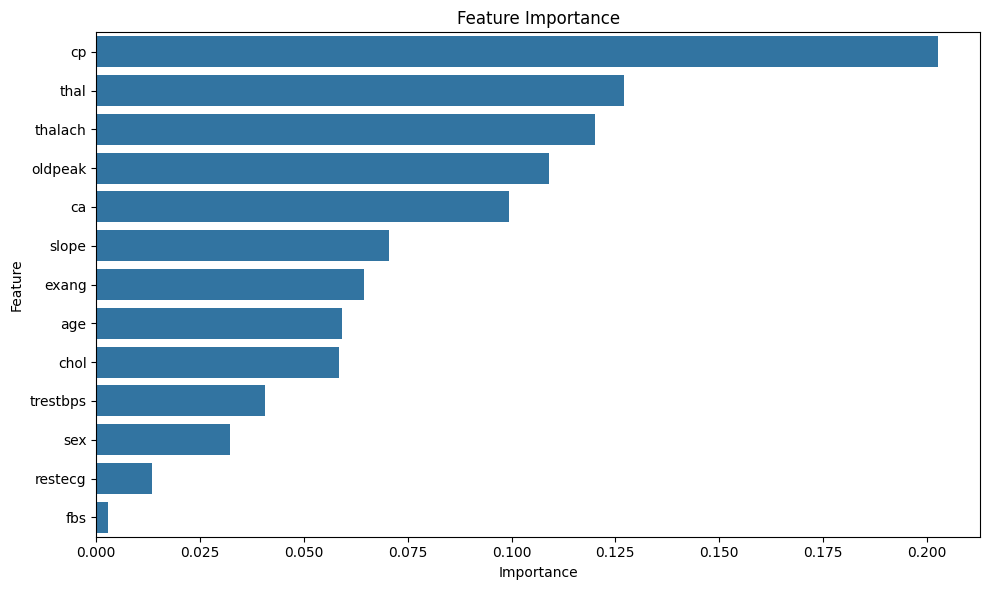

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [40]:
best_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)
print("\nTraining Accuracy:", best_model.score(X_train_scaled, y_train))
print("Testing Accuracy:", best_model.score(X_test_scaled, y_test))

Best Parameters:
 {'class_weight': {0: np.float64(1.1), 1: np.float64(0.9166666666666666)}, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Training Accuracy: 0.9256198347107438
Testing Accuracy: 0.8524590163934426


In [41]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [42]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.80      0.97      0.88        33

    accuracy                           0.85        61
   macro avg       0.88      0.84      0.85        61
weighted avg       0.87      0.85      0.85        61

Confusion Matrix:
 [[20  8]
 [ 1 32]]
ROC AUC Score: 0.9036796536796536


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Convert list [0, 1] to numpy array
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)

# Make it usable in a model
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [27]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced', class_weight_dict]
}

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Example parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Random Forest inside GridSearchCV
model = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model to training data
model.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", model.best_params_)
print("Best Accuracy Score:", model.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy Score: 0.8391156462585034


In [30]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7377
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.50      0.64        28
           1       0.69      0.94      0.79        33

    accuracy                           0.74        61
   macro avg       0.78      0.72      0.72        61
weighted avg       0.77      0.74      0.72        61

Confusion Matrix:
 [[14 14]
 [ 2 31]]


c:\Users\asmit\OneDrive\Desktop\sem6\ccl7\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [31]:
importances = model.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)


Feature Importance:
      Feature  Importance
2         cp    0.175162
7    thalach    0.119497
12      thal    0.116169
9    oldpeak    0.111292
11        ca    0.085353
4       chol    0.078575
0        age    0.070966
10     slope    0.065775
8      exang    0.063926
3   trestbps    0.058005
1        sex    0.029659
6    restecg    0.018495
5        fbs    0.007127


In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8361
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Confusion Matrix:
 [[24  5]
 [ 5 27]]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [3]:
# print first 5 rows of the dataset
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# print last 5 rows of the dataset
heart_data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [5]:
# number of rows and columns in the dataset
heart_data.shape

(303, 14)

In [6]:
# getting some info about the data
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# checking for missing values
heart_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
# statistical measures about the data
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [9]:
# checking the distribution of Target Variable
heart_data['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

1 --> Defective Heart

0 --> Healthy Heart

Splitting the Features and Target

In [10]:
X = heart_data.drop(columns='target', axis=1)
Y = heart_data['target']

In [11]:
print(X)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  
0        0   0     1  
1        0   0     2  
2        2   0    

In [12]:
print(Y)

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64


Splitting the Data into Training data & Test Data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [14]:
print(X.shape, X_train.shape, X_test.shape)

(303, 13) (242, 13) (61, 13)


Model Training

Logistic Regression

In [15]:
model = LogisticRegression()
model = SVC(probability=True)

In [16]:
# training the LogisticRegression model with Training data
model.fit(X_train, Y_train)

SVC(probability=True)

Model Evaluation

Accuracy Score

In [17]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [18]:
print('Accuracy on Training data : ', training_data_accuracy)

Accuracy on Training data :  0.6942148760330579


In [19]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [20]:
print('Accuracy on Test data : ', test_data_accuracy)

Accuracy on Test data :  0.6229508196721312


Building a Predictive System

In [21]:
input_data = (62,0,0,140,268,0,0,160,0,3.6,0,2,2)

# change the input data to a numpy array
input_data_as_numpy_array= np.asarray(input_data)

# reshape the numpy array as we are predicting for only on instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model.predict(input_data_reshaped)
print(prediction)

if (prediction[0]== 0):
  print('The Person does not have a Heart Disease')
else:
  print('The Person has Heart Disease')

[1]
The Person has Heart Disease


c:\Users\sanik\Downloads\multiple-disease-prediction-streamlit-app-main\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Saving the trained model

In [22]:
import pickle

In [23]:
filename = 'heart_disease_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [24]:
# loading the saved model
loaded_model = pickle.load(open('heart_disease_model.sav', 'rb'))

In [25]:
for column in X.columns:
  print(column)

age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
